In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, RidgeCV, Ridge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import KFold, RepeatedKFold,GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import pickle
from pprint import pprint

In [2]:
# ignore FutureWarning messages in scikit-learn

from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

# 1 - Defining the task

After analyzing the results from the baseline model, I had to options in my mind:

    1. Predict BVPC for each campaign, using results from the first 80% days of 
    campaigns, and predict on the last 20% of the days.
    
    2. Predict clicks and booking_value for each campaign, taking into consideration 
    only the information that we have before the campaign start.
    
I decided to follow the **second approach**, I will explain why.

**Predict clicks and booking_values for each campaign** - Notice that we have 2 dependent variables.

The baseline model tested how good is our prediction after some days of campaign running, although, assuming that we want Trivago Bidding algorithm start working as soon as the client sets its campaign, creating a model to predict clicks and booking value based on hotelier features seems a reason method, and it could complement the idea of the baseline model.


## 1.1 - The math behind it

Why am I predicting clicks and booking value if the task is to predict an ideal CPC bid?

Well, if we predict clicks and booking value, we can calculate the BVPC, and having in mind that the we have a target CPA of at least 15%, after predicting the BVPC I can easily calculate CPC Bid = Predicted BVPC * 15%

## 1.2 - Read data

In [3]:
df1 = pd.read_csv('df1_final.csv')
df1 = df1.drop(columns=['Unnamed: 0'])

/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
# Select only the columns that will be used for prediction
df1 = df1[['hotel_id', 'locale', 'city', 'country', 'abc_category',
           'stars', 'rating','campaign_id','campaign_duration', 
           'direct_booking_value_per_campaign','direct_clicks_per_campaign']]

## 1.3 - Transform the dataset and engineer some features (again)

In [5]:
# set rating to numeric, and those values that are null, I will insert rating = 7401, cause it's the most frequent rating value
df1['rating'] = df1['rating'].apply(lambda x: int(x) if x != '\\N' else 7401)

In [6]:
# we will drop the duplicates as we are not working with information for each day
df1 = df1.drop_duplicates()

I added a feature that counts the frequency of hotel_id

As hotel_id is a numeric value, the model could make the assumption the wrong assumption about its meaning, and setting it to a categorical value, would make the dataset huge. I assume that counting the frequency is a good method to use in this case.

In [7]:
frequency_hotel_id = df1.groupby('hotel_id').locale.count().reset_index().rename(columns={'locale':'frequency_hotel_id'})
df1 = df1.merge(frequency_hotel_id)

In [8]:
df1.to_csv('final.csv')

## 1.4 - Get dummies and Train/Test Split

In [9]:
dff = df1.drop(columns=['hotel_id'])

dff = pd.get_dummies(dff, columns=['locale','city','country','abc_category'])

In [10]:
X = dff.drop(columns=['direct_booking_value_per_campaign', 'direct_clicks_per_campaign'])

# Select our target/dependent variable
y = dff[['direct_booking_value_per_campaign', 'direct_clicks_per_campaign']]

# Split the data into training/testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.33, random_state=42)

## 2 - Analyzing dependent variables

I used hte following materials as resources to analyze the dependent variables.

https://scikit-learn.org/stable/auto_examples/ensemble/plot_random_forest_regression_multioutput.html

http://hb.diva-portal.org/smash/get/diva2:1309070/FULLTEXT01

http://astrohackweek.org/blog/multi-output-random-forests.html

In [11]:
y = y.values

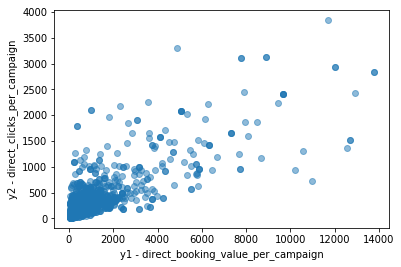

In [12]:
fig, ax = plt.subplots()
ax.plot(y[:, 0], y[:, 1], 'o', alpha=0.5)

ax.set_xlabel('y1 - direct_booking_value_per_campaign'); ax.set_ylabel('y2 - direct_clicks_per_campaign');

In [15]:
from sklearn.ensemble import RandomForestRegressor

clf1 = RandomForestRegressor(100).fit(X_train.drop(columns=['campaign_id']), y_train)
Ypred1 = clf1.predict(X_test.drop(columns=['campaign_id']))


In [ ]:
fig, ax = plt.subplots()
ax.plot(Ypred1[:, 0], Ypred1[:, 1], 'o', alpha=0.5)

ax.set_xlabel('y1 - direct_booking_value_per_campaign'); ax.set_ylabel('y2 - direct_clicks_per_campaign');

In [18]:
class MultiOutputRF(object):
    def __init__(self, *args, **kwargs):
        self.args = args
        self.kwargs = kwargs
        
    def fit(self, X, Y):
        X, Y = map(np.atleast_2d, (X, Y))
        assert X.shape[0] == Y.shape[0]
        Ny = Y.shape[1]
        
        self.clfs = []
        for i in range(Ny):
            clf = RandomForestRegressor(*self.args, **self.kwargs)
            Xi = np.hstack([X, Y[:, :i]])
            yi = Y[:, i]
            self.clfs.append(clf.fit(Xi, yi))
            
        return self
        
    def predict(self, X):
        Y = np.empty([X.shape[0], len(self.clfs)])
        for i, clf in enumerate(self.clfs):
            Y[:, i] = clf.predict(np.hstack([X, Y[:, :i]]))
        return Y

In [19]:
clf2 = MultiOutputRF(100).fit(X_train.drop(columns=['campaign_id']), y_train)
Ypred2 = clf2.predict(X_test.drop(columns=['campaign_id']))

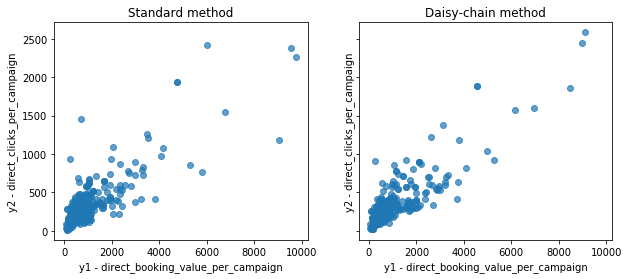

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)
    
ax[0].plot(Ypred1[:, 0], Ypred1[:, 1], 'o', alpha=0.7)
ax[1].plot(Ypred2[:, 0], Ypred2[:, 1], 'o', alpha=0.7)

ax[0].set_title("Standard method")
ax[1].set_title("Daisy-chain method")

ax[0].set_xlabel('y1 - direct_booking_value_per_campaign'); 
ax[0].set_ylabel('y2 - direct_clicks_per_campaign');

ax[1].set_xlabel('y1 - direct_booking_value_per_campaign'); 
ax[1].set_ylabel('y2 - direct_clicks_per_campaign');

# 3 - Predict dependent variables y1 and y2

This regression task has an unique charcteristics, it has 2 outputs (two dependend variables).

I've done some research about what is the best algorithm for a Multi-OutPut regression task, although, as I am not familiar with some applications that I've read about, I preferred to create separate model to predict y1 and y2

In [21]:
# y_train
y_train = y_train.values
y_test = y_test.values

In [22]:
y1_cost_train = y_train[:, 0]
y2_clicks_train = y_train[:, 1]

y1_cost_test = y_test[:, 0]
y2_clicks_test = y_test[:, 1]

### direct_booking_value_per_campaign

In [23]:
X_train.columns

Index(['stars', 'rating', 'campaign_id', 'campaign_duration',
       'frequency_hotel_id', 'locale_DE', 'locale_ES', 'locale_FR',
       'locale_IT', 'locale_UK',
       ...
       'country_Romania', 'country_Slovenia', 'country_Spain',
       'country_Switzerland', 'country_United Kingdom', 'abc_category_A',
       'abc_category_B', 'abc_category_C1', 'abc_category_C2',
       'abc_category_C3'],
      dtype='object', length=545)

In [24]:
cv = RepeatedKFold(n_splits=12, n_repeats=15)
regr_rf1 = GridSearchCV(RandomForestRegressor(), cv=cv, verbose=1,
                  param_grid={"max_depth": np.arange(2,50,3)})

regr_rf1.fit(X_train.drop(columns=['campaign_id']), y1_cost_train)
y1_cost_pred = regr_rf1.predict(X_test.drop(columns=['campaign_id']))
print(regr_rf1.best_params_);

# model evaluation
print('Random Forest absolute error: ', mean_absolute_error(y1_cost_test, y1_cost_pred))
print('Random Forest squared error: ',mean_squared_error(y1_cost_test, y1_cost_pred))

print(regr_rf1.best_score_)

Fitting 180 folds for each of 16 candidates, totalling 2880 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


{'max_depth': 32}
Random Forest absolute error:  732.5640587246213
Random Forest squared error:  2146147.302875735
0.3403637574708291


[Parallel(n_jobs=1)]: Done 2880 out of 2880 | elapsed:  5.4min finished


In [45]:
# regr_rf1.cv_results_

In [26]:
pickle.dump(regr_rf1, open('y1_cost_pred1.pkl','wb'))

### Predict direct_clicks_per_campaign

In [27]:
cv = RepeatedKFold(n_splits=6, n_repeats=10)
regr_rf2 = GridSearchCV(RandomForestRegressor(), cv=cv, verbose=1,
                  param_grid={"max_depth": np.arange(2,100,3)})
#regr_dt = DecisionTreeRegressor(max_depth=2)
regr_rf2.fit(X_train.drop(columns=['campaign_id']), y2_clicks_train)
y2_clicks_pred = regr_rf2.predict(X_test.drop(columns=['campaign_id']))
print(regr_rf2.best_params_);

# model evaluation
print('Random Forest absolute error: ', mean_absolute_error(y2_clicks_test, y2_clicks_pred))
print('Random Forest squared error: ',mean_squared_error(y2_clicks_test, y2_clicks_pred))

print(regr_rf2.best_score_)

Fitting 60 folds for each of 33 candidates, totalling 1980 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


{'max_depth': 38}
Random Forest absolute error:  156.90587200740012
Random Forest squared error:  84235.2653944885
0.48802247137726923


[Parallel(n_jobs=1)]: Done 1980 out of 1980 | elapsed:  3.5min finished


In [28]:
pickle.dump(regr_rf2, open('y2_clicks_pred1.pkl','wb'))

## 3.1 - Analyzing Model Performance

Predicting the number of clicks and the booking_values for each campaign, before the campaign start, is not an easy task.

Although, by analyzing the results above, and imagining that if someone would set a random CPC bid, we would likely be better in estimating the right CPC, as the model can predict 48% of variability of the sum of clicks, and 34% of the booking value by campaign.

Again, this is not an optimal result, and it would be good to analyze how TRIVAGO algorithm can predict those values to really access the benefit of this prediction.

## 3.2 - Create dataframe with results

This will be the csv sent for challenge evaluation.

In [55]:
X2 = X

In [57]:
X2['y1_booking_value_pred'] = regr_rf1.predict(X.drop(columns=['campaign_id']))
X2['y2_clicks_pred'] = regr_rf2.predict(X.drop(columns=['campaign_id','y1_booking_value_pred']))

In [53]:
X2['predicted_bvpc'] = X2['y1_booking_value_pred'] / X2['y2_clicks_pred']

In [64]:
dd = pd.read_csv('df1_final.csv')
dd = dd.drop(columns=['Unnamed: 0'])

dd = dd[['direct_booking_value_per_campaign','direct_clicks_per_campaign','campaign_id']]
dd = dd.drop_duplicates()

In [59]:
X2 = X2.merge(dd, on='campaign_id')

In [73]:
X2['book_val_error'] = X2['y1_booking_value_pred'] - X2['direct_booking_value_per_campaign']
X2['clicks_error'] = X2['y2_clicks_pred'] - X2['direct_clicks_per_campaign']

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [74]:
X2 = X2[['stars', 'rating', 'campaign_id', 'campaign_duration',
       'frequency_hotel_id', 'y1_booking_value_pred', 'y2_clicks_pred',
       'predicted_bvpc', 'direct_booking_value_per_campaign',
       'direct_clicks_per_campaign', 'book_val_error', 'clicks_error']]

In [75]:
X2['target_cpc_bid'] = X2['predicted_bvpc'] * 0.15

In [78]:
X2.head()

,stars,rating,campaign_id,campaign_duration,frequency_hotel_id,y1_booking_value_pred,y2_clicks_pred,predicted_bvpc,direct_booking_value_per_campaign,direct_clicks_per_campaign,book_val_error,clicks_error,target_cpc_bid
0,4,8153,8967_DE,89,1,1147.926952,265.695652,4.320458,1207.0,278,-59.073048,-12.304348,0.648069
1,4,8208,9664_IT,89,1,390.187722,297.300000,1.312438,146.0,230,244.187722,67.300000,0.196866
2,4,8940,12685_DE,89,1,531.891955,583.700000,0.911242,595.0,672,-63.108045,-88.300000,0.136686
3,3,7963,13493_FR,89,3,538.023828,134.600000,3.997205,216.0,73,322.023828,61.600000,0.599581
4,3,7963,13493_IT,89,3,571.901704,385.600000,1.483148,828.0,294,-256.098296,91.600000,0.222472


In [79]:
X2.to_csv('results/final_predictions.csv')

# 4 - Analyzing feature importance for dependent variable

**feat_imp_book_value**

In [89]:
feature_list = list(X_train.drop(columns=['campaign_id']).columns)

# Get numerical feature importances
importances = list(regr_rf1.best_estimator_.feature_importances_)

# List of tuples with variable and importance
feature_importances_book_value = [[feature, round(importance, 5)] for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
# feature_importances_book_value = sorted(feature_importances, key = lambda x: x[1], reverse = True)

feature_importances_book_value = pd.DataFrame(feature_importances_book_value).rename(columns={0:'feature',1:'feat_imp_book_value'})

**feat_impf_clicks**

In [90]:
feature_list = list(X_train.drop(columns=['campaign_id']).columns)

# Get numerical feature importances
importances = list(regr_rf2.best_estimator_.feature_importances_)

# List of tuples with variable and importance
feature_importances = [[feature, round(importance, 5)] for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
# for i in feature_importances[:34]:
#     print(i)

# Convert feature_importances to a df
feature_importances = pd.DataFrame(feature_importances).rename(columns={0:'feature',1:'feat_imp_clicks'})

In [91]:
feature_importances = feature_importances.merge(feature_importances_book_value, on='feature')

As we can see on the graph below, most of the coefficients were set to zero, as those features were not important to the model

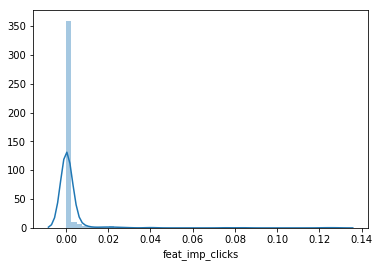

In [93]:
sns.distplot(feature_importances['feat_imp_clicks'])

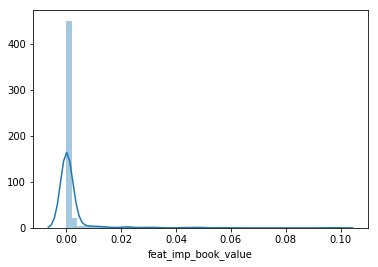

In [101]:
sns.distplot(feature_importances['feat_imp_book_value'])

In [95]:
feature_importances['rank_feat_imp_clicks'] = feature_importances['feat_imp_clicks'].rank(ascending=False) 
feature_importances['rank_feat_imp_book_value'] = feature_importances['feat_imp_book_value'].rank(ascending=False) 

In [98]:
feature_importances.head()

,feature,feat_imp_clicks,feat_imp_book_value,rank_feat_imp_clicks,rank_feat_imp_book_value
0,abc_category_A,0.12749,0.04472,1.0,6.0
1,rating,0.12261,0.09782,2.0,1.0
2,locale_IT,0.08393,0.04861,3.0,4.0
3,city_Puerto de la Cruz,0.07587,0.05752,4.0,2.0
4,abc_category_B,0.04066,0.02209,5.0,16.0


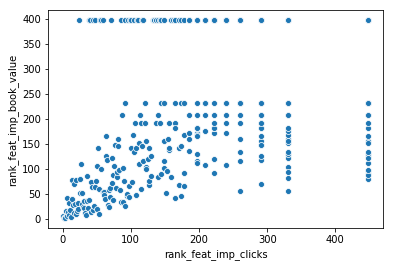

In [100]:
sns.scatterplot(x="rank_feat_imp_clicks", y="rank_feat_imp_book_value", data=feature_importances)

The importance of each feature for predicting each dependent variable are follows a linear relationship. 

The variables that explains one dependent variable, let's say clicks, are also good in explaining the other (booking_value).

# 5 - Future Work

* Deeper analysis on feature importance and coefficients - this is basic, although I couldn't manage to do so, due to time constraint

* Compare predicted CPC bid with actual bid for each campaign, remembering that we are only considering campaign that reached more than 15% CPA, and analyzing the effects of this prediction in terms of improving campaign performance.

* It would be useful to analyze performance metrices like CTR, BVPC and sum of costs by campaign, after implementing this CPC bid prediction.

* Develop a model to predict CPC bid for each day after a given "training" period of performance (as explained on the task definition in the beginning of this notebook)